#### code that reads teh radiosonde data and calculates mean profiles over sst bins
#### Author: Claudia Acquistapace
#### date: 09/12/2021
#### goal: reads the radiosonde data and calculate mean profiles over sst bins and store them in ncdf file for plotting purposes


In [1]:
# importing necessary libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.dates as mdates
import glob
#from myFunctions import lcl
#from myFunctions import f_closest
from warnings import warn
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy import interpolate
import custom_color_palette as ccp
from matplotlib import rcParams
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'
def f_generate_list_binned_var(var_list, var_name_string):
    output_list = []
    n_elements_list = len(var_list)
    for i,el in enumerate(var_list):
        output_list.append(el[var_name_string].values)
    return(output_list)



In [2]:

# read radiosonde data
#path_rs_data = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/binned_sst/'
path_rs_data = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/'
#RS_atalante_Data = xr.open_dataset(path_rs_data+'radiosondes_atalante_binned_sst.nc')

RS_atalante_Data = xr.open_dataset(path_rs_data+'radiosondes_atalante_merian_binned_sst.nc')

# reading variables for calculating mean vars profiles
sst_tsg_RS = RS_atalante_Data['sst'].values

# building binned array of sst
bin_size = 0.25
binned_sst = np.round(np.arange(np.nanmin(sst_tsg_RS),np.nanmax(sst_tsg_RS), bin_size),1)
print(len(binned_sst))
binned_sst

#defining color palette for subsequent plots
colors_binned_sst = plt.cm.seismic(np.linspace(0, 1, len(binned_sst)))

6


In [3]:
binned_sst

array([26.3, 26.6, 26.8, 27.1, 27.3, 27.6])

In [4]:
for ind_sst in range(len(binned_sst)-1):
    print(ind_sst)

0
1
2
3
4


In [5]:


# calculating mean and std properties for each bin of sst
list_binned_datasets = []
list_test = []
for ind_sst in range(len(binned_sst)):
    
    # slicing the bin of sst selected
    #sliced_data_SST = RS_atalante_Data_new.sel(sst=slice(binned_sst[ind_sst], binned_sst[ind_sst+1]))
    # slicing the bin of sst selected
    if ind_sst < len(binned_sst)-2:
        sliced_data_SST = RS_atalante_Data.sel(sst=slice(binned_sst[ind_sst], binned_sst[ind_sst+1]))
        print(binned_sst[ind_sst])
        print(binned_sst[ind_sst+1])
    elif ind_sst == len(binned_sst)-2:
        print('last bin')
        print(binned_sst[ind_sst])
        print(np.nanmax(RS_atalante_Data.sst.values))
        sliced_data_SST = RS_atalante_Data.sel(sst=slice(binned_sst[ind_sst], np.nanmax(RS_atalante_Data.sst.values)))
    else:
        break
        
    # saving the slice in a list
    list_binned_datasets.append(sliced_data_SST)
    
    # calculating quantiles of the slice
    list_test.append(sliced_data_SST.quantile([0, 0.25, 0.5, 0.75, 1], dim="sst", skipna=True))
    

# calculate label marks for bins
sst_bin_label = []
for ind in range(len(binned_sst)-1):
    if ind == 0:
        sst_bin_label.append(round((np.nanmin(RS_atalante_Data.sst.values)+binned_sst[ind+1])/2,2))
    elif ind < len(binned_sst)-2:
        sst_bin_label.append(round((binned_sst[ind]+binned_sst[ind+1])/2,2))
    else:
        sst_bin_label.append(round((binned_sst[ind]+np.nanmax(RS_atalante_Data.sst.values))/2,2))


26.3
26.6


/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


26.6
26.8
26.8
27.1
27.1
27.3
last bin
27.3
27.6695


In [6]:

#generate data arrays for boxplots of scalar quantities
lts_binned = f_generate_list_binned_var(list_binned_datasets, 'lts')
eis_binned = f_generate_list_binned_var(list_binned_datasets, 'eis')
lcl_binned = f_generate_list_binned_var(list_binned_datasets, 'lcl')
pblh_binned = f_generate_list_binned_var(list_binned_datasets, 'pblh')
cbh_binned = f_generate_list_binned_var(list_binned_datasets, 'cbh')
cf_binned = f_generate_list_binned_var(list_binned_datasets, 'cf')


    

In [7]:
sst_bin_label

[26.47, 26.7, 26.95, 27.2, 27.48]

In [8]:

# removing nans from the cloud base height data
cbh_binned_nonans = []
for ind,el in enumerate(cbh_binned):
    cbh_binned_test = el
    cbh_binned_nonans.append(cbh_binned_test[~np.isnan(cbh_binned_test)])
sst_bin_label

[26.47, 26.7, 26.95, 27.2, 27.48]

In [9]:
list_std_binned_datasets = []
list_mean_binned_datasets = []

# calculate mean profile and std for each bin
for ind,el in enumerate(list_binned_datasets):
    # calculating mean and standard deviation
    list_mean_binned_datasets.append(el.mean(dim='sst', skipna=True))
    list_std_binned_datasets.append(el.std(dim='sst', skipna=True))
    
# define matrices of data for each of the variables
P_bin = np.zeros((len(sst_bin_label), len(list_binned_datasets[0]['height'].values)))
T_bin = np.zeros((len(sst_bin_label), len(list_binned_datasets[0]['height'].values)))
MR_bin = np.zeros((len(sst_bin_label), len(list_binned_datasets[0]['height'].values)))
THETA_bin = np.zeros((len(sst_bin_label), len(list_binned_datasets[0]['height'].values)))
THETA_V_bin = np.zeros((len(sst_bin_label), len(list_binned_datasets[0]['height'].values)))
H_DIR_bin = np.zeros((len(sst_bin_label), len(list_binned_datasets[0]['height'].values)))
H_SPEED_bin = np.zeros((len(sst_bin_label), len(list_binned_datasets[0]['height'].values)))
RH_bin = np.zeros((len(sst_bin_label), len(list_binned_datasets[0]['height'].values)))

for ind_dataset, DS in enumerate(list_mean_binned_datasets):
    P_bin[ind_dataset, :] = DS['pressure'].values
    T_bin[ind_dataset, :] = DS['ta'].values
    MR_bin[ind_dataset, :] = DS['wvmr'].values
    THETA_bin[ind_dataset, :] = DS['theta'].values
    THETA_V_bin[ind_dataset, :] = DS['theta_v'].values
    H_DIR_bin[ind_dataset, :] = DS['wind_dir'].values
    H_SPEED_bin[ind_dataset, :] = DS['wind_speed'].values
    RH_bin[ind_dataset, :] = DS['rh'].values

list_matrices = [P_bin, T_bin, MR_bin, THETA_bin, THETA_V_bin, H_DIR_bin, H_SPEED_bin, RH_bin]

(0.0, 3000.0)

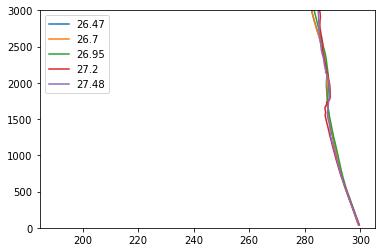

In [10]:
for ind in range(len(sst_bin_label)):
    plt.plot(T_bin[ind,:],list_binned_datasets[0]['height'].values, label=str(sst_bin_label[ind]))
plt.legend()
plt.ylim(0., 3000.)

In [11]:
var_list =['P', 'T','WVMR','THETA','THETA_V','H_DIR', 'H_SPEED', 'RH']
list_matrices = [P_bin, T_bin, MR_bin, THETA_bin, THETA_V_bin, H_DIR_bin, H_SPEED_bin, RH_bin]
T_dict = {
     'var_name'  : 'T',
     'var_units' : ' $^{\circ}$K'}
P_dict = {
     'var_name'  : 'P',
     'var_units' : ' Pa'}
THETA_dict = {
     'var_name'  : 'THETA',
     'var_units' : ' $^{\circ}$K'}
THETA_V_dict = {
     'var_name'  : 'THETA_V',
     'var_units' : ' $^{\circ}$K'}
WVMR_dict = {
     'var_name'  : 'MR',
     'var_units' : ' g kg$^{-1}$'}
H_DIR_dict = {
     'var_name'  : 'H_DIR',
     'var_units' : ' $^{\circ}$'}
H_SPEED_dict = {
     'var_name'  : 'H_SPEED',
     'var_units' : 'ms$^{-1}Z$'}
RH_dict = {
     'var_name'  : 'RH',
     'var_units' : '%'}
dict_list = [P_dict, T_dict, WVMR_dict, THETA_dict, THETA_V_dict, H_DIR_dict, H_SPEED_dict, RH_dict]

In [12]:
# converting the list of dictionaries in a dictionary called variables to be saved in ncdf
dims             = ['sst','height']
coords           = {'sst':sst_bin_label, 'height':list_binned_datasets[0]['height'].values}
variables = {}
for i, DS in enumerate(list_matrices):
    key = dict_list[i]['var_name']
    value = xr.DataArray(dims=dims, coords=coords, data=DS,
                             attrs={'long_name':dict_list[i]['var_name'],
                                   'units':dict_list[i]['var_units']})

    variables[key] = value


global_attributes = {'CREATED_BY'       : 'Claudia Acquistapace',
                        'CREATED_ON'       :  str(datetime.now()),
                        'FILL_VALUE'       :  'NaN', 
                        'PI_NAME'          : 'Claudia Acquistapace',
                        'PI_AFFILIATION'   : 'University of Cologne (UNI), Germany', 
                        'PI_ADDRESS'       : 'Institute for geophysics and meteorology, Pohligstrasse 3, 50969 Koeln', 
                        'PI_MAIL'          : 'cacquist@meteo.uni-koeln.de',
                        'DATA_DESCRIPTION' : 'with the diurnal cycle removed from the data',
                        'DATA_DISCIPLINE'  : 'Atmospheric Physics - Remote Sensing Lidar Profiler',
                        'DATA_GROUP'       : 'Experimental;Profile;Moving',
                        'DATA_SOURCE'      : 'arthus data',
                        'DATA_PROCESSING'  : 'https://github.com/ClauClouds/SST-impact/',
                        'INSTRUMENT_MODEL' : 'arthus raman lidar system',
                         'COMMENT'         : 'original data postprocessed by Diego Lange' }
dataset_out    = xr.Dataset(data_vars = variables,
                        coords = coords,
                        attrs = global_attributes)
dataset_out
dataset_out.to_netcdf('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/binned_sst/RS_mean_profiles_binned_sst_4.nc')


['SST = 26.47', 'SST = 26.7', 'SST = 26.95', 'SST = 27.2', 'SST = 27.48']


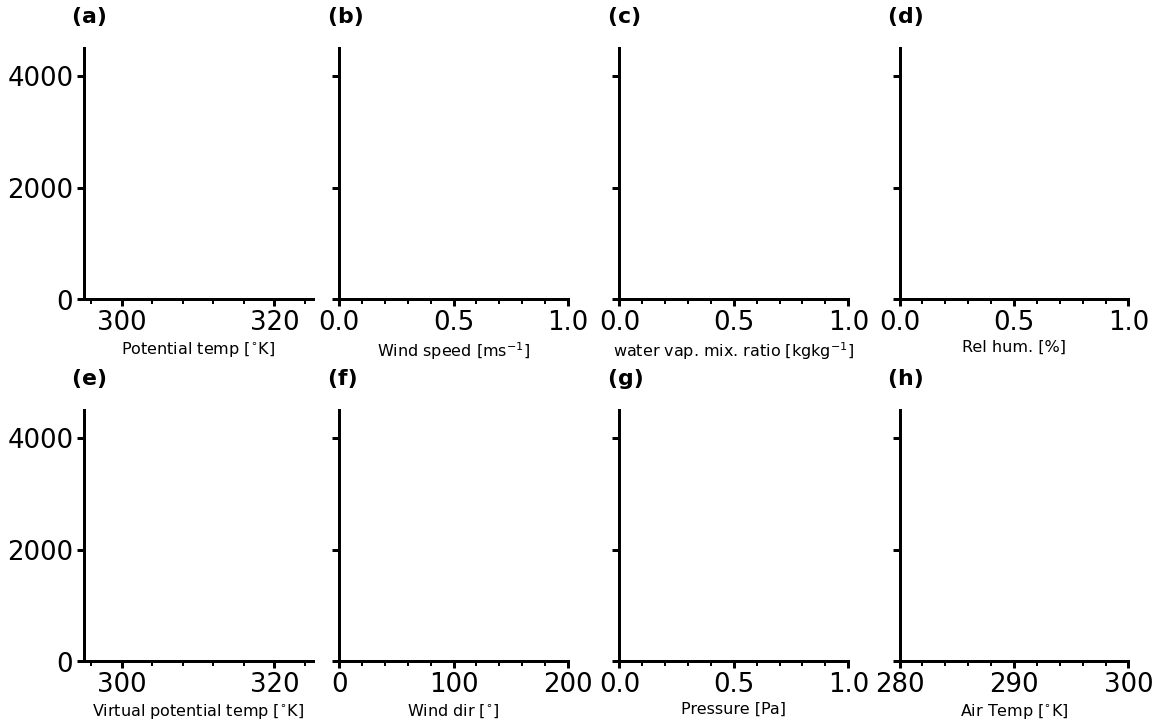

In [13]:
fig, axs = plt.subplots(2, 4, figsize=(16,10), sharey=True, constrained_layout=True)
import matplotlib.font_manager as font_manager
grid = True
matplotlib.rc('xtick', labelsize=36)  # sets dimension of ticks in the plots
matplotlib.rc('ytick', labelsize=36) # sets dimension of ticks in the plots
labelsizeaxes   = 16
fontSizeTitle   = 16
fontSizeX       = 16
fontSizeY       = 16
cbarAspect      = 16
fontSizeCbar    = 16
labels =[]
for ind, el in enumerate(sst_bin_label):
    labels.append('SST = '+str(el))
print(labels)
font = font_manager.FontProperties(family='Tahoma',
                                   weight='light',
                                   style='normal', size=12)
for ind_dataset in range(len(binned_sst)-1):
    
    #plot dataset mean and std of the radiosondes
    #axs[0,0].plot(DS['theta'].values, DS['height'].values, color=colors_binned_sst[ind_dataset], label=labels[ind_dataset], rasterized=True)
    #axs[0,0].legend(frameon=False, prop=font)
    axs[1,0].plot(dataset_out['RH'].values[ind_dataset,:], dataset_out['height'].values, color=colors_binned_sst[ind_dataset], label=labels[ind_dataset], rasterized=True)
    #axs[0,1].plot(DS['wind_speed'].values, DS['height'].values, color=colors_binned_sst[ind_dataset], label=labels[ind_dataset], rasterized=True)
    #axs[1,1].plot(DS['wind_dir'].values, DS['height'].values, color=colors_binned_sst[ind_dataset], label=labels[ind_dataset], rasterized=True)
    #axs[0,2].plot(DS['wvmr'].values, DS['height'].values, color=colors_binned_sst[ind_dataset], label=labels[ind_dataset], rasterized=True)
    ##axs[1,2].plot(DS['pressure'].values, DS['height'].values, color=colors_binned_sst[ind_dataset], label=labels[ind_dataset], rasterized=True)
    #axs[0,3].plot(DS['rh'].values, DS['height'].values, color=colors_binned_sst[ind_dataset], label=labels[ind_dataset], rasterized=True)
    #axs[1,3].plot(DS['ta'].values, DS['height'].values, color=colors_binned_sst[ind_dataset], label=labels[ind_dataset], rasterized=True)


    #axs[0].set_xlim(290.,325.)
axs[0,0].set_xlim(295., 325.)
axs[0,0].set_xlabel('Potential temp [$^{\circ}$K]', fontsize=fontSizeX)
axs[1,0].set_xlim(295., 325.)
axs[1,0].set_xlabel('Virtual potential temp [$^{\circ}$K]', fontsize=fontSizeX)
axs[0,1].set_xlabel('Wind speed [ms$^{-1}$]', fontsize=fontSizeX)
axs[1,1].set_xlabel('Wind dir [$^{\circ}$]', fontsize=fontSizeX)
axs[1,1].set_xlim(0., 200.)
axs[1,3].set_xlim(280., 300.)
axs[0,3].set_xlabel('Rel hum. [%]', fontsize=fontSizeX)
axs[0,2].set_xlabel('water vap. mix. ratio [kgkg$^{-1}$]', fontsize=fontSizeX)
axs[1,2].set_xlabel('Pressure [Pa]', fontsize=fontSizeX)
axs[1,3].set_xlabel('Air Temp [$^{\circ}$K]', fontsize=fontSizeX)
#axs[1,2].set_xlim(50000, 1000020)
for ax, l in zip(axs[:].flatten(), ['(a) ',  '(b) ',  '(c) ',  '(d) ', '(e) ', '(f) ', '(g) ', '(h) ']):
    ax.text(-0.05, 1.1, l,  fontweight='black', fontsize=22, transform=ax.transAxes)
    ax.set_ylim(0., 4500.)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(3)
    ax.spines["left"].set_linewidth(3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(which='minor', length=5, width=2)
    ax.tick_params(which='major', length=7, width=3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(axis='both', labelsize=26)
fig.savefig(path_out_plots+'profiles_binned_sst.png')


['SST = 26.47', 'SST = 26.7', 'SST = 26.95', 'SST = 27.2', 'SST = 27.48']


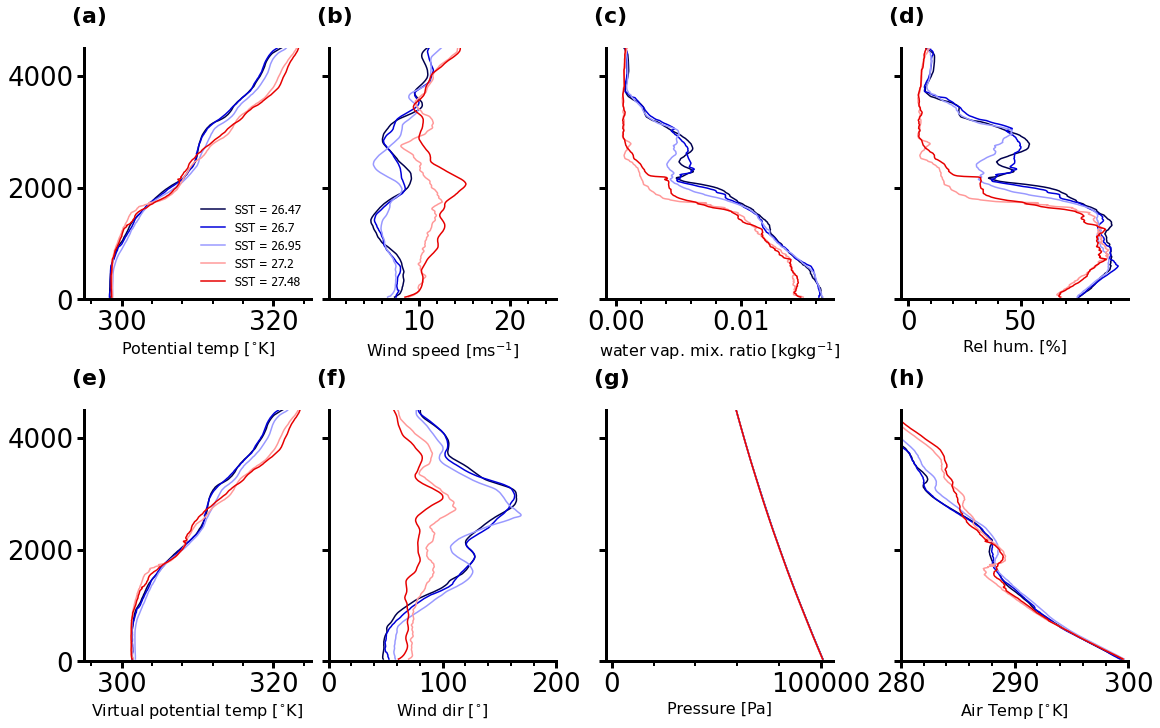

In [14]:
fig, axs = plt.subplots(2, 4, figsize=(16,10), sharey=True, constrained_layout=True)
import matplotlib.font_manager as font_manager
grid = True
matplotlib.rc('xtick', labelsize=36)  # sets dimension of ticks in the plots
matplotlib.rc('ytick', labelsize=36) # sets dimension of ticks in the plots
labelsizeaxes   = 16
fontSizeTitle   = 16
fontSizeX       = 16
fontSizeY       = 16
cbarAspect      = 16
fontSizeCbar    = 16
labels =[]
for ind, el in enumerate(sst_bin_label):
    labels.append('SST = '+str(el))
print(labels)
font = font_manager.FontProperties(family='Tahoma',
                                   weight='light',
                                   style='normal', size=12)
for ind_dataset,DS in enumerate(list_mean_binned_datasets):
    
    #plot dataset mean and std of the radiosondes
    axs[0,0].plot(DS['theta'].values, DS['height'].values, color=colors_binned_sst[ind_dataset], label=labels[ind_dataset], rasterized=True)
    axs[0,0].legend(frameon=False, prop=font)
    axs[1,0].plot(DS['theta_v'].values, DS['height'].values, color=colors_binned_sst[ind_dataset], label=labels[ind_dataset], rasterized=True)
    axs[0,1].plot(DS['wind_speed'].values, DS['height'].values, color=colors_binned_sst[ind_dataset], label=labels[ind_dataset], rasterized=True)
    axs[1,1].plot(DS['wind_dir'].values, DS['height'].values, color=colors_binned_sst[ind_dataset], label=labels[ind_dataset], rasterized=True)
    axs[0,2].plot(DS['wvmr'].values, DS['height'].values, color=colors_binned_sst[ind_dataset], label=labels[ind_dataset], rasterized=True)
    axs[1,2].plot(DS['pressure'].values, DS['height'].values, color=colors_binned_sst[ind_dataset], label=labels[ind_dataset], rasterized=True)
    axs[0,3].plot(DS['rh'].values, DS['height'].values, color=colors_binned_sst[ind_dataset], label=labels[ind_dataset], rasterized=True)
    axs[1,3].plot(DS['ta'].values, DS['height'].values, color=colors_binned_sst[ind_dataset], label=labels[ind_dataset], rasterized=True)


    #axs[0].set_xlim(290.,325.)
axs[0,0].set_xlim(295., 325.)
axs[0,0].set_xlabel('Potential temp [$^{\circ}$K]', fontsize=fontSizeX)
axs[1,0].set_xlim(295., 325.)
axs[1,0].set_xlabel('Virtual potential temp [$^{\circ}$K]', fontsize=fontSizeX)
axs[0,1].set_xlabel('Wind speed [ms$^{-1}$]', fontsize=fontSizeX)
axs[1,1].set_xlabel('Wind dir [$^{\circ}$]', fontsize=fontSizeX)
axs[1,1].set_xlim(0., 200.)
axs[1,3].set_xlim(280., 300.)
axs[0,3].set_xlabel('Rel hum. [%]', fontsize=fontSizeX)
axs[0,2].set_xlabel('water vap. mix. ratio [kgkg$^{-1}$]', fontsize=fontSizeX)
axs[1,2].set_xlabel('Pressure [Pa]', fontsize=fontSizeX)
axs[1,3].set_xlabel('Air Temp [$^{\circ}$K]', fontsize=fontSizeX)
#axs[1,2].set_xlim(50000, 1000020)
for ax, l in zip(axs[:].flatten(), ['(a) ',  '(b) ',  '(c) ',  '(d) ', '(e) ', '(f) ', '(g) ', '(h) ']):
    ax.text(-0.05, 1.1, l,  fontweight='black', fontsize=22, transform=ax.transAxes)
    ax.set_ylim(0., 4500.)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(3)
    ax.spines["left"].set_linewidth(3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(which='minor', length=5, width=2)
    ax.tick_params(which='major', length=7, width=3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(axis='both', labelsize=26)
fig.savefig(path_out_plots+'profiles_binned_sst.png')


In [26]:
sst_bin_label

[26.45, 26.7, 26.95, 27.2, 27.45]

In [66]:
sst_bin_label

[26.45, 26.7, 26.95, 27.2, 27.45]